In [25]:
# !pip install matplotlib pandas wordcloud
import os
from pyspark.find_spark_home import _find_spark_home
from pyspark.sql import SparkSession
from pyspark import SparkConf, StorageLevel
import pyspark.sql.functions as F
from pyspark.sql.functions import col, count

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from dotenv import load_dotenv
load_dotenv()

print(_find_spark_home())

C:\Users\liisu\anaconda3\envs\bigData\Lib\site-packages\pyspark


In [26]:
python_path = os.environ.get('PYTHON_PATH')
app_name_dec = os.environ.get('APP_NAME_DEC')
hadoop_path_dec = os.environ.get('HADOOP_DEC_DATASET_PATH')

In [27]:
conf = SparkConf()\
    .setMaster('local[*]')\
    .set('spark-local-dir', "C:\\spark-temp")\
    .set('spark.driver.memory', '4g')\
    .set('spark.executor.memory', '4g')\
    .set('spark.driver.maxResultSize', '2g')\
    .set('spark.pyspark.python', python_path)\
    .set('spark.pyspark.driver.python', python_path)\
    .set("spark.network.timeout","800s")\
    .set("spark.dynamicAllocation.enabled", "true")\
    .set("spark.shuffle.service.enabled", "true")\
    .set("spark.dynamicAllocation.minExecutors", "1")\
    .set("spark.dynamicAllocation.maxExecutors", "10")\
    .set("spark.dynamicAllocation.executorIdleTimeout", "60s")\

spark = SparkSession.builder.appName(app_name_dec).config(conf=conf).getOrCreate()
sc = spark.sparkContext

for item in sc.getConf().getAll(): print(item)

('spark.driver.host', 'host.docker.internal')
('spark.app.submitTime', '1703879311456')
('spark.dynamicAllocation.minExecutors', '1')
('spark.app.startTime', '1703882451357')
('spark.shuffle.service.enabled', 'true')
('spark.driver.memory', '4g')
('spark.executor.memory', '4g')
('spark.dynamicAllocation.maxExecutors', '10')
('spark.executor.id', 'driver')
('spark.pyspark.driver.python', 'C:/Users/liisu/anaconda3/envs/bigData/python.exe')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.

In [28]:
df = spark.read.csv(hadoop_path_dec+'/selected_Data/', header = True, inferSchema = True)
df.show()

+------------+----------+----------+-------+-------+---------+------------+------------------+---+
|          id|event_type|product_id|  brand|  price|  user_id|    category|           product|day|
+------------+----------+----------+-------+-------+---------+------------+------------------+---+
|481036420269|      view|  15200237|   akom|   79.8|586571708|   furniture|       bedroom.bed| 26|
|137439894419|      view|   3700245|philips| 113.04|518441916|  appliances|environment.vacuum| 10|
|438087353571|      view|  31200669|   ikea|   1.26|516126769| electronics|   audio.subwoofer| 24|
|472446909723|      view|   1005253| xiaomi| 265.13|592256709|construction|       tools.light| 26|
|206158674575|  purchase| 100005789|hyundai|  218.8|516641300|       sport|           trainer| 14|
|120259247306|      view|   1004258|  apple| 773.64|564420733|construction|       tools.light|  8|
|128849631247|      view|   1005145|  apple|1827.33|516055680|construction|       tools.light|  9|
|489627234

### Question:
Which are the most sold categories of products for each month?

Which were the most sold top 10 brands?

In [5]:
df_sales = df.filter(col("event_type") == "purchase")

df_grouped = df_sales.groupBy("category").agg(count("id").alias("sales_count"))

df_top10 = df_grouped.orderBy(col("sales_count").desc()).limit(10)

df_top10.show()

+------------+-----------+
|    category|sales_count|
+------------+-----------+
|construction|     513806|
|  appliances|     163635|
|     apparel|      91649|
| electronics|      84729|
|       sport|      67901|
|   furniture|      31466|
|   computers|      26039|
|        kids|      14424|
| accessories|       6276|
|        auto|       5824|
+------------+-----------+



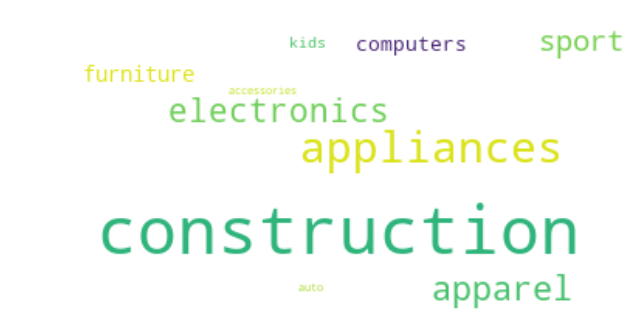

In [6]:
rows = df_top10.collect()
frequencies = {row['category']: row['sales_count'] for row in rows}

wc = WordCloud(background_color="white")
wc.generate_from_frequencies(frequencies)

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(10)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
for row in df_top10.collect():
    print(row)

Row(category='construction', sales_count=513806)
Row(category='appliances', sales_count=163635)
Row(category='apparel', sales_count=91649)
Row(category='electronics', sales_count=84729)
Row(category='sport', sales_count=67901)
Row(category='furniture', sales_count=31466)
Row(category='computers', sales_count=26039)
Row(category='kids', sales_count=14424)
Row(category='accessories', sales_count=6276)
Row(category='auto', sales_count=5824)


In [8]:
df_sales = df.filter(col("event_type") == "view")

df_grouped = df_sales.groupBy("category").agg(count("id").alias("view_count"))

df_top10 = df_grouped.orderBy(col("view_count").desc()).limit(10)

df_top10.show()

+------------+----------+
|    category|view_count|
+------------+----------+
|construction|  15873789|
|  appliances|  10321246|
|     apparel|   6824523|
| electronics|   6237862|
|       sport|   2995544|
|   furniture|   2399403|
|   computers|   2388011|
|        kids|   1345026|
| accessories|    728651|
|        auto|    503282|
+------------+----------+



In [9]:
df_sales = df.filter(col("event_type") == "purchase")

df_grouped = df_sales.groupBy("brand").agg(count("id").alias("sales_count_brand"))

df_top10 = df_grouped.orderBy(col("sales_count_brand").desc()).limit(10)

df_top10.show()

+-------+-----------------+
|  brand|sales_count_brand|
+-------+-----------------+
|samsung|           265773|
|  apple|           209511|
| xiaomi|           101500|
| huawei|            45118|
|lucente|            21010|
|   oppo|            19843|
|   sony|            16526|
|     lg|            16191|
|  artel|             9211|
| lenovo|             8711|
+-------+-----------------+



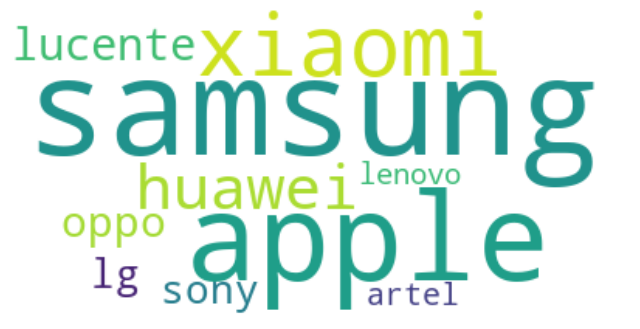

In [10]:
rows = df_top10.collect()
frequencies = {row['brand']: row['sales_count_brand'] for row in rows}

wc = WordCloud(background_color="white")
wc.generate_from_frequencies(frequencies)

fig = plt.figure()
fig.set_figwidth(8)
fig.set_figheight(10)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
df_sales = df.filter(col("event_type") == "view")

df_grouped = df_sales.groupBy("brand").agg(count("id").alias("view_count_brand"))

df_top10 = df_grouped.orderBy(col("view_count_brand").desc()).limit(10)

df_top10.show()

+-------+----------------+
|  brand|view_count_brand|
+-------+----------------+
|samsung|         7563547|
|  apple|         4880173|
| xiaomi|         4738632|
| huawei|         1736478|
|lucente|         1159695|
|     lg|          878712|
|   sony|          844867|
|   oppo|          703464|
| lenovo|          601244|
|  bosch|          533426|
+-------+----------------+



### Question:
How many times did the customer view the product before purchasing it?

In [12]:
# Apply filter early and select only necessary columns
views_df = df.filter(df.event_type == 'view').select('user_id', 'product_id', 'day').withColumnRenamed('day', 'day_view')
purchases_df = df.filter(df.event_type == 'purchase').select('user_id', 'product_id', 'day', 'product', 'category', 'brand', 'price').withColumnRenamed('day', 'day_purchase')

# Join on user_id and product_id (using regular join here)
joined_df = views_df.join(purchases_df, ['user_id', 'product_id'], 'inner')

# Cache joined_df if it will be used multiple times
# joined_df.cache()

# Ensure views are before purchase and filter
valid_views_df = joined_df.filter(joined_df.day_view <= joined_df.day_purchase)

# Group and aggregate
final_df = valid_views_df.groupBy('user_id', 'product_id', 'product', 'category', 'brand', 'price').agg(F.count('day_view').alias('views_before_purchase'))

# Show the final DataFrame
final_df.show()

+---------+----------+--------------------+------------+----------+-------+---------------------+
|  user_id|product_id|             product|    category|     brand|  price|views_before_purchase|
+---------+----------+--------------------+------------+----------+-------+---------------------+
|136662675|   1005008|         tools.light|construction|    xiaomi| 102.65|                    1|
|237353186|  26405135| peripherals.printer|   computers|   sokolov| 248.86|                    4|
|306072928|   2701627|kitchen.refrigera...|  appliances|        lg|2007.49|                    3|
|312267737|   1005217|         tools.light|construction|    xiaomi| 142.08|                    8|
|363037756| 100032815|               skirt|     apparel|       ast|   6.23|                    1|
|393237889|   1005173|kitchen.refrigera...|  appliances|   samsung| 643.23|                    1|
|414865253| 100029429|accessories.compr...|        auto|rusgoldart| 324.85|                    4|
|415354502|   100510

In [13]:
# Order final_df by views_before_purchase in descending order
sorted_final_df = final_df.orderBy(F.desc('views_before_purchase'))

# Show the sorted DataFrame
sorted_final_df.show()

+---------+----------+--------------------+------------+-------+-------+---------------------+
|  user_id|product_id|             product|    category|  brand|  price|views_before_purchase|
+---------+----------+--------------------+------------+-------+-------+---------------------+
|553431815|   1005107|         tools.light|construction|  apple|1041.97|                30268|
|579154915|   2201033|     bedroom.blanket|   furniture|  canon| 592.01|                16578|
|576154686|   4804718|             bicycle|       sport|  apple| 326.39|                15797|
|556958338|   1004903|         tools.light|construction| huawei|  76.94|                15114|
|549154245|   1004246|         tools.light|construction|  apple| 785.01|                14776|
|522271001|   1005211|         tools.light|construction|samsung| 170.15|                11607|
|513901034|   1004249|         tools.light|construction|  apple| 746.22|                 9894|
|552109237|  26201108|   components.faucet|constru

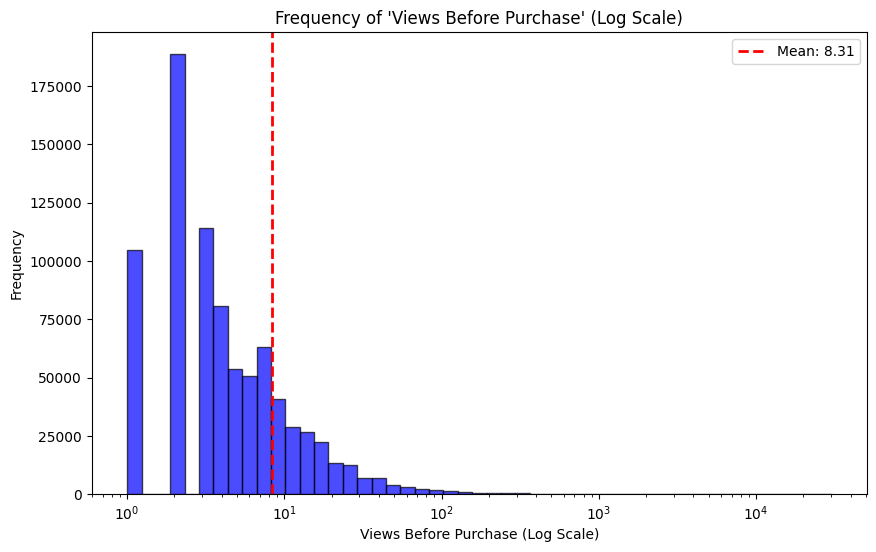

In [14]:
# Convert the specific column to Pandas for visualization
views_before_purchase_pd = final_df.select('views_before_purchase').toPandas()

# Create a histogram for the views
plt.figure(figsize=(10, 6))
plt.hist(views_before_purchase_pd['views_before_purchase'], bins=np.logspace(np.log10(1), np.log10(views_before_purchase_pd['views_before_purchase'].max()), 50), alpha=0.7, color='blue', edgecolor='black')
plt.gca().set_xscale("log")

# Calculate and show mean
mean_value = views_before_purchase_pd['views_before_purchase'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

title = "Frequency of 'Views Before Purchase' (Log Scale)"
plt.title(title)
plt.xlabel('Views Before Purchase (Log Scale)')
plt.ylabel('Frequency')
plt.legend()

plt.show()

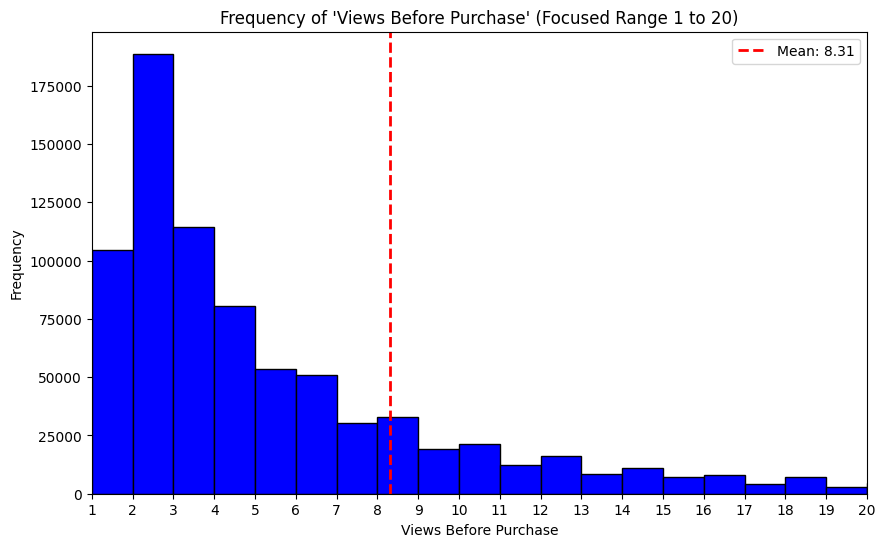

In [15]:
# Assuming views_before_purchase_pd is a Pandas DataFrame with the 'views_before_purchase' column

# Determine the upper bound for the histogram
upper_bound = views_before_purchase_pd['views_before_purchase'].quantile(0.95)

# Plot the histogram focusing on the most common values
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(views_before_purchase_pd['views_before_purchase'], 
                                 bins=range(1, int(upper_bound) + 1), 
                                 edgecolor='black', 
                                 color='blue')

# Set the x-axis limit to include only 1 to 20
plt.xlim(1, 20)

# Calculate and show mean
mean_value = views_before_purchase_pd['views_before_purchase'].mean()
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')

# Set the x-axis ticks to show every number from 1 to 20
plt.xticks(range(1, 21))

# Title and labels
plt.title("Frequency of 'Views Before Purchase' (Focused Range 1 to 20)")
plt.xlabel('Views Before Purchase')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [16]:
print("Top 5 Most Frequent 'Views Before Purchase':")

# Calculate the top 5 most frequent 'views_before_purchase' values along with their frequencies
top5_freq = views_before_purchase_pd['views_before_purchase'].value_counts().nlargest(5)

# Creating a DataFrame for a better presentation
top5_table = pd.DataFrame({
    'Views Before Purchase': top5_freq.index,
    'Frequency': top5_freq.values
})

# Display the table
print(top5_table)

Top 5 Most Frequent 'Views Before Purchase':
   Views Before Purchase  Frequency
0                      2     188664
1                      3     114226
2                      1     104643
3                      4      80620
4                      5      53573


C:\Users\liisu\AppData\Local\Temp\ipykernel_25720\3673483.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_views_per_category = final_pd.groupby('price_category')['views_before_purchase'].mean()


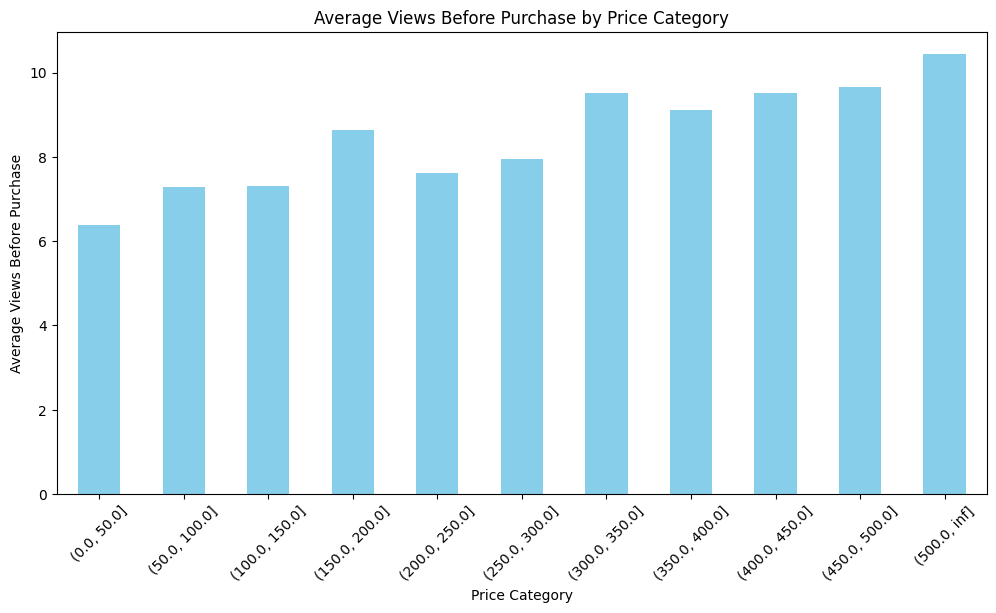

In [18]:
# Assuming final_df is your Spark DataFrame with necessary columns
# Convert the DataFrame to Pandas for visualization
final_pd = final_df.toPandas()

# Define price bins - adjust these based on your data's price range
price_bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, np.inf]
final_pd['price_category'] = pd.cut(final_pd['price'], bins=price_bins)

# Calculate average views per price category
avg_views_per_category = final_pd.groupby('price_category')['views_before_purchase'].mean()

# Create a bar chart
plt.figure(figsize=(12, 6))
avg_views_per_category.plot(kind='bar', color='skyblue')

# Adding labels and title
plt.title('Average Views Before Purchase by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Average Views Before Purchase')

# Show the plot
plt.xticks(rotation=45)
plt.show()

### Question
Which were the most purchased and viewed products?

In [19]:
# Group by product_id, brand, and product, and pivot on event_type to get counts of views and purchases
product_event_counts = df.groupBy("product_id", "brand", "product") \
                             .pivot("event_type") \
                             .count()

# Replace null values with 0 in view and purchase columns for accurate counting
product_event_counts = product_event_counts.na.fill(value=0, subset=["view", "purchase"])

In [20]:
most_viewed = product_event_counts.orderBy(F.desc("view")).select("product", "view")

print("Most Viewed Products:")
most_viewed.show()

Most Viewed Products:
+--------------------+------+
|             product|  view|
+--------------------+------+
|         tools.light|704209|
|         tools.light|553145|
|         tools.light|491605|
|         tools.light|347399|
|         tools.light|321313|
|         tools.light|287146|
|             bicycle|277432|
|         tools.light|248844|
|         tools.light|242808|
|         tools.light|236560|
|kitchen.refrigera...|230710|
|         tools.light|215666|
|         tools.light|201481|
|         tools.light|198461|
|               shoes|194934|
|         tools.light|185213|
|         tools.light|180036|
|             bicycle|170617|
|         tools.light|159713|
|         tools.light|152685|
+--------------------+------+
only showing top 20 rows



In [21]:
most_purchased = product_event_counts.orderBy(F.desc("purchase")).select("product", "purchase")

print("Most Purchased Products:")
most_purchased.show()

Most Purchased Products:
+--------------------+--------+
|             product|purchase|
+--------------------+--------+
|         tools.light|   34545|
|         tools.light|   34256|
|         tools.light|   26464|
|         tools.light|   23457|
|             bicycle|   22496|
|         tools.light|   18606|
|         tools.light|   13637|
|         tools.light|   12071|
|         tools.light|   11435|
|         tools.light|   10850|
|         tools.light|   10256|
|         tools.light|   10159|
|               shoes|    9380|
|         tools.light|    7648|
|         tools.light|    6956|
|         tools.light|    6918|
|         tools.light|    6558|
|         tools.light|    6431|
|         tools.light|    6180|
|kitchen.refrigera...|    6176|
+--------------------+--------+
only showing top 20 rows



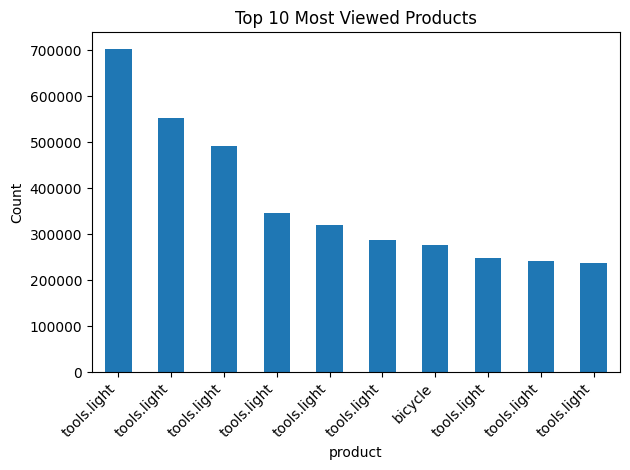

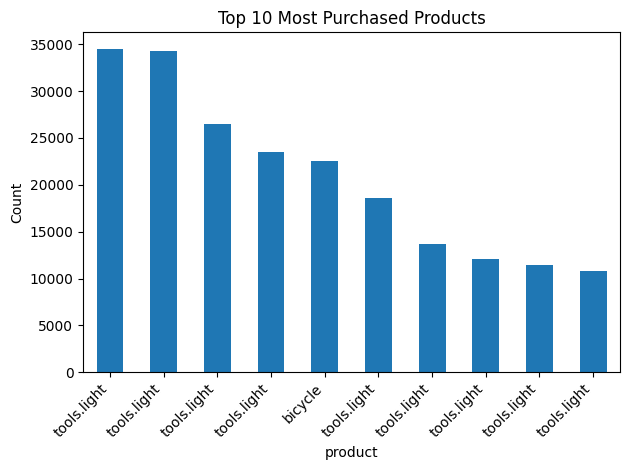

In [22]:
# Convert to Pandas DataFrame for easier plotting
most_viewed_pd = most_viewed.limit(10).toPandas()
most_purchased_pd = most_purchased.limit(10).toPandas()

# Define a function for plotting
def plot_top_products(df, title, y_label):
    df.plot(kind='bar', x='product', y=y_label, legend=None)
    plt.title(title)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')  # Rotate product names for better readability
    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()

# Plotting the most viewed products
plot_top_products(most_viewed_pd, 'Top 10 Most Viewed Products', 'view')

# Plotting the most purchased products
plot_top_products(most_purchased_pd, 'Top 10 Most Purchased Products', 'purchase')

spark.stop()

### Question:
What was the period of time with most purchases?
- During which part of the month - beginning, mid, end

In [29]:
#  checking nr of purchases each day

purchases = df.filter(col("event_type") == "purchase")

daily_purchases = purchases.groupBy("day").count()
sorted_daily_purchases = daily_purchases.orderBy("day")

sorted_daily_purchases.show(n=sorted_daily_purchases.count())

+---+-----+
|day|count|
+---+-----+
|  1|24115|
|  2|24106|
|  3|20822|
|  4|20843|
|  5|21789|
|  6|23735|
|  7|23306|
|  8|22287|
|  9|23340|
| 10|23546|
| 11|22393|
| 12|22661|
| 13|23150|
| 14|22779|
| 15|30207|
| 16|55687|
| 17|44617|
| 18|42407|
| 19|41384|
| 20|39752|
| 21|37845|
| 22|38500|
| 23|40156|
| 24|38890|
| 25|38953|
| 26|38589|
| 27|38061|
| 28|39958|
| 29|43703|
| 30|45197|
| 31|34705|
+---+-----+



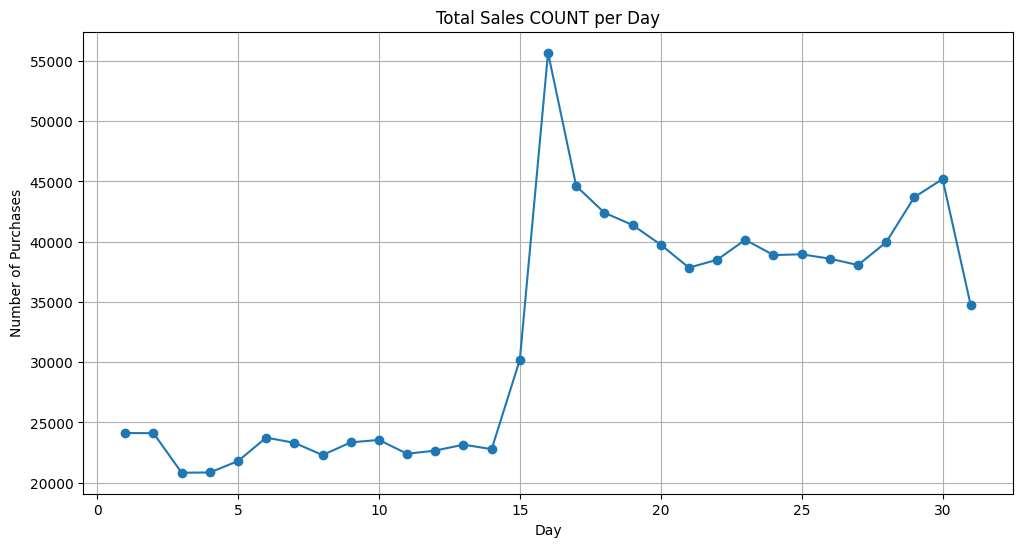

In [30]:
# amount of sales
pandas_df = sorted_daily_purchases.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['day'], pandas_df['count'], marker='o')
plt.title('Total Sales COUNT per Day')
plt.xlabel('Day')
plt.ylabel('Number of Purchases')
plt.grid(True)
plt.show()

In [31]:
purchases = df.filter(F.col("event_type") == "purchase")

daily_purchases_sum = purchases.groupBy("day").agg(F.sum("price").alias("total_sales"))

formatted_daily_purchases_sum = daily_purchases_sum.select(
    "day",
    F.format_number("total_sales", 2).alias("total_sales_formatted")
)
sorted_daily_purchases_sum = formatted_daily_purchases_sum.orderBy("day")
daily_ordered = daily_purchases_sum.orderBy("day")

sorted_daily_purchases_sum.show(n=sorted_daily_purchases_sum.count())

+---+---------------------+
|day|total_sales_formatted|
+---+---------------------+
|  1|         7,639,255.61|
|  2|         7,770,816.29|
|  3|         6,981,118.66|
|  4|         6,928,181.75|
|  5|         7,062,674.02|
|  6|         7,687,568.99|
|  7|         7,546,747.99|
|  8|         7,095,540.15|
|  9|         7,738,367.38|
| 10|         7,839,283.41|
| 11|         7,256,905.17|
| 12|         7,442,170.11|
| 13|         7,415,751.30|
| 14|         7,236,447.44|
| 15|        10,075,864.01|
| 16|        19,192,940.25|
| 17|        14,479,711.72|
| 18|        13,786,622.56|
| 19|        13,290,268.33|
| 20|        12,587,880.16|
| 21|        11,918,218.01|
| 22|        12,136,360.98|
| 23|        13,066,758.42|
| 24|        12,609,119.82|
| 25|        12,416,531.44|
| 26|        12,427,137.66|
| 27|        12,074,179.57|
| 28|        12,537,291.88|
| 29|        13,611,560.08|
| 30|        14,353,303.36|
| 31|        11,284,149.41|
+---+---------------------+



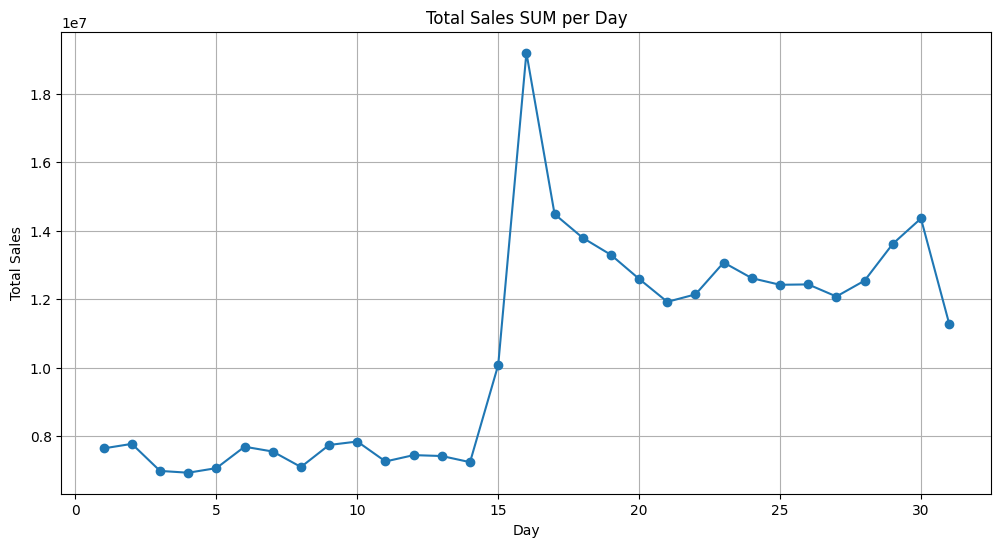

In [32]:
# Total sum of sales
pandas_df = daily_ordered.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(pandas_df['day'], pandas_df['total_sales'], marker='o')
plt.title('Total Sales SUM per Day')
plt.xlabel('Day')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()


### Question:
Total price of sales for the month

In [33]:
total_sales_sum = daily_ordered.agg(F.sum("total_sales").alias("total_sales_sum"))

total_sales_sum_value = total_sales_sum.collect()[0]["total_sales_sum"]
formatted_total_sales_sum = f"{total_sales_sum_value:,.2f}"

print("Total Sales Sum:", formatted_total_sales_sum)

Total Sales Sum: 325,488,725.93
